In [7]:
import os
print os.getcwd()

/Users/nickens/development/mccullen_thesis_gcp/February


In [11]:
%matplotlib inline
import pysal as ps
import numpy as np
import pandas as pd
import descartes
import geopandas as gp
import shapely
import copy
import random
import os
import sys
import r'acs_regionalization as ACS
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 40,40  #set  the   default   map   size  
rcParams['patch.linewidth'] = 1  #set default polygon line width

SyntaxError: unexpected character after line continuation character (<ipython-input-11-4e6f5898d785>, line 12)

[]

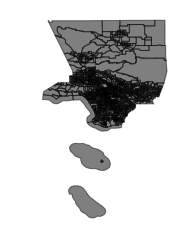

In [3]:
# read in the Austin shapefile and plot it
shp_map = gp.read_file('LAC_Census_Tracts.shp')
shp_map['constant'] = 1
p = shp_map.plot('constant', alpha=0.5, cmap='gist_heat', edgecolor="k")
p.axis('off')
p.plot()

In [4]:
# read spatial data into python and run some diagnostics
w = ps.rook_from_shapefile('LAC_Census_Tracts.shp', idVariable='GEOID')
print(w.n) # number of census tracts

2346


Text(0,0.5,'number of tracts')

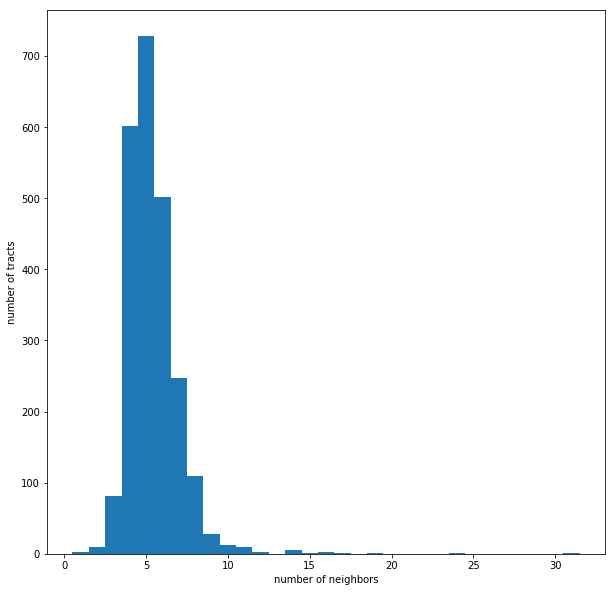

In [5]:
# summary of the connectivity structure of the Los Angeles County census tracts
w_hist_data = np.array(w.histogram)
fig, ax = plt.subplots(figsize=(10,10))
ax.bar(w_hist_data[:,0], w_hist_data[:,1], align='center', width=1)
ax.set_xlabel('number of neighbors')
ax.set_ylabel('number of tracts')

In [ ]:
# read in list of census tracts to exclude
# using arcmap to view zoning data overlaid on census tracts symbolized by total population estimate per tract
#exclude = open('Exclude_Test.csv')
#exclude = exclude.readline()
#exclude = exclude.replace('g','')
#exclude = exclude.split(',')
#print exclude

In [6]:
# read in the ACS estimates and standard errors
population = pd.read_csv('ACS_Full_Table_Copy1.csv', index_col=0)
pop2 = pd.read_csv('Total_Population.csv', index_col=0)
est_perc = pd.read_csv('prop_est_vet_perc.csv', index_col=0)
# csv file of estimated total veteran population by census tract.
est_vet_pop = pd.read_csv('proportion1.csv', index_col=0)
# standard error csv by census tract.
stderr_pop = pd.read_csv('std_err_prop.csv', index_col=0)
# margin of error calculation 
# moe_pop = stderr_pop * 1.65  # changed from 1.645 to 1.65 to reduce decimal places in analysis
moe_prop = stderr_pop * 1.65  
# read the census tract ids into a python object 
pop_tract_ids = open('tract_ids.csv')
# split the csv into a python list object
pop_tract_ids = pop_tract_ids.readline().split(',')
# calculate the estimate ratio, standard error ratio, and margin of error for each census tract as a python object
est_ratio = pd.read_csv('est_ratio5.csv', index_col=0) 
std_ratio = pd.read_csv('std_err_prop.csv', index_col=0)
# print (est_ratio.dtypes)
moe_ratio = std_ratio * 1.65

# population_ratio.csv is a CSV file with the census tract id and the above ratio names as columns.
ratio_names = open('population_ratio.csv') # need to create this file tonight
ratio_names = ratio_names.readline().split(',') 

In [7]:
# ratio and population data is organized as numerator-denominator pairs
print ratio_names
print est_ratio.columns  # names of the numerators and denominators
print 'the numerator of %s is %s, and the denominator is %s'%(ratio_names[0], population.columns[3], population.columns[6])
print 'the numerator of %s is %s, and the denominator is %s'%(ratio_names[1], population.columns[1], population.columns[6])

print (est_ratio.values)
print (est_vet_pop.values)
#print (stderr_pop.values)

['vet_per_tract', 'civ_per_tract']
Index([u'vet_est', u'civ_est'], dtype='object')
the numerator of vet_per_tract is vet_moe, and the denominator is total_pop_est
the numerator of civ_per_tract is civ_moe, and the denominator is total_pop_est
[[    1     1]
 [    1     1]
 [    1     1]
 ...
 [  855  8859]
 [  385  9080]
 [    1 10223]]
[[    1     1     1     1]
 [    1     1     1     1]
 [    1     1     1     1]
 ...
 [ 9080  9465   385  9465]
 [ 8859  9714   855  9714]
 [10223 10223     1 10223]]


In [ ]:
# depending on what the machine size of the Virtual Machine, the algorthim can take several minutes to complete.
# i am currently using a first generation Google Cloud Platform Compute Engine Virtual Machine size n1-standard-4.
# this machine has 4 virtual CPU cores and 8gb of RAM.

# open the shapefile of the census tracts.
shp = ps.open('LAC_Census_Tracts.shp')
# using a random seed in python generates a random number and using the same seed value ensures that the same results are generated.
# if a random seed is not used, I cant reliably check that the same result comes from each execution of the code, 
# since the code uses pseudorandom numbers in the ACS Regionalization algorythm.
              
random.seed(745)     # to ensure we get the same solution each time
np.random.seed(745)  # to ensure we get the same solution each time
results = ACS.ACS_Regions(w=w,\
                          target_est_prop=est_vet_pop.values,\
                          target_moe_prop=moe_prop.values,\
                          target_est_ratio=est_ratio.values,\
                          target_moe_ratio=moe_ratio.values,\
                          count_est=population.values,\
                          target_th_all=0.05,\
                          compactness=shp)
print 'regionalization finished'

utils.py:133: RuntimeWarning: divide by zero encountered in divide
  cv = sde / est


In [ ]:
# some basic diagnostics on the solution
print 'number of regions:', len(results.regions)
print 'total time (seconds):', results.time['total']

In [ ]:
# This is a python function to create the side by side plots of LA County

# We'll make a few side-by-side plots. This code wraps the setup into a function. This will plot out the two maps
# of LA County before and after regionalization.
def two_plot_setup():
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(40,40))
    axes[0].set_aspect('equal')
    axes[1].set_aspect('equal')
    axes[0].axis('off')
    axes[1].axis('off')
    return fig, axes

In [ ]:
#This cell calls the above function and actually creates the two plots.

fig, axes = two_plot_setup()

# color tracts based on region ID  #This shows all the 
rids = copy.copy(results.region_ids)
shp_map['rids'] = rids
shp_map.plot('rids', categorical=True, alpha=1, colormap='Dark2', axes=axes[0])

# disolve the tracts into regions
region_groups = shp_map.groupby('rids')
region_map = gp.GeoDataFrame(index=region_groups.indices.keys())
region_map['rids'] = region_groups.indices.keys()
region_map['geometry'] = region_groups.geometry.apply(shapely.ops.unary_union)
region_map.plot('rids', categorical=True, alpha=1, colormap='Dark2', axes=axes[1])